# 5. Hypothesis Testing and Test Statistics

**Pedagogical context.** This notebook covers Cowan's Lectures 6 and 7
(statistical tests, test statistics, multivariate methods), Prosper's
Lectures 6 through 9 (frequentist inference), and the CCGV paper
(arXiv:1007.1727) which defines the test statistics used by every LHC
search.

The Neyman-Pearson lemma establishes that the likelihood ratio is the
most powerful test statistic for distinguishing two simple hypotheses.
In particle physics, the hypotheses are composite (they depend on unknown
nuisance parameters), so we use the *profile* likelihood ratio: the
nuisance parameters are set to their conditional MLEs at each tested
value of the parameter of interest. The CCGV paper defines three bounded
variants of this ratio ($q_0$, $q_\mu$, $\tilde{q}_\mu$) whose
asymptotic distributions are known analytically, enabling p-value
computation without expensive Monte Carlo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import fit
from histimator.inference import profile_likelihood_ratio, discovery_significance
from histimator.test_statistics import (
    compute_q0, compute_qmu, compute_qtilde_mu,
    pvalue_q0, pvalues_qmu, pvalues_qtilde_mu,
)

## 5.1 The profile likelihood ratio

The unbounded profile likelihood ratio test statistic is:

$$t(\mu) = 2 \left[ \ell(\mu, \hat{\hat{\boldsymbol{\nu}}}) - \ell(\hat{\mu}, \hat{\boldsymbol{\nu}}) \right]$$

where $\hat{\hat{\boldsymbol{\nu}}}$ are the nuisance parameters that
minimise the NLL with $\mu$ fixed (the conditional MLE), and
$(\hat{\mu}, \hat{\boldsymbol{\nu}})$ are the global MLE. By Wilks'
theorem, $t(\mu)$ is asymptotically distributed as $\chi^2(1)$ under
the hypothesis that $\mu$ is the true value.

This is a two-sided test: large values of $t(\mu)$ reject $\mu$
regardless of whether the data fluctuated up or down. Discovery and
exclusion require one-sided tests, which is why the CCGV paper defines
bounded variants.

In [2]:
# Build a standard test model
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
signal = Sample("signal", Histogram([3, 10, 15, 10, 3], edges))
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

background = Sample("background", Histogram([50, 60, 55, 45, 40], edges))
background.add_normsys("bkg_norm", lo=0.9, hi=1.1)

# Inject signal at mu = 1.5
np.random.seed(42)
true_mu = 1.5
exp = true_mu * signal.histogram.values + background.histogram.values
data = np.random.poisson(exp.astype(int))

ch = Channel("SR")
ch.add_sample(signal)
ch.add_sample(background)
ch.set_data(data)

model = Model("test_stats_demo")
model.add_channel(ch)

# Compute unbounded PLR at a few mu values
result = fit(model)
print(f"Best fit: mu = {result.bestfit['mu']:.3f}")
for mu_test in [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]:
    t = profile_likelihood_ratio(model, "mu", mu_test,
                                 unconditional_nll=result.nll_min)
    print(f"  t({mu_test:.1f}) = {t:.3f}")

Best fit: mu = 1.258
  t(0.0) = 4.988
  t(0.5) = 1.849
  t(1.0) = 0.218
  t(1.5) = 0.199
  t(2.0) = 1.827
  t(3.0) = 10.188


## 5.2 Discovery: the $q_0$ test statistic

For discovery, we test the background-only hypothesis ($\mu = 0$). The
$q_0$ statistic is:

$$q_0 = \begin{cases} 2[\ell(0, \hat{\hat{\boldsymbol{\nu}}}) - \ell(\hat{\mu}, \hat{\boldsymbol{\nu}})] & \text{if } \hat{\mu} \geq 0 \\ 0 & \text{if } \hat{\mu} < 0 \end{cases}$$

The boundary at $\hat{\mu} < 0$ reflects the physical reasoning that a
data deficit should never count as evidence *for* new signal. Under the
background-only hypothesis, $q_0$ follows a half-$\chi^2(1)$
distribution: it is zero with probability 1/2 (when $\hat{\mu}$
fluctuates negative) and $\chi^2(1)$ with probability 1/2.

The discovery p-value is $p_0 = 1 - \Phi(\sqrt{q_0})$, and the
significance in standard deviations is $Z = \sqrt{q_0}$. The 5$\sigma$
discovery threshold corresponds to $q_0 = 25$.

In [3]:
q0, mu_hat = compute_q0(model, "mu")
p0 = pvalue_q0(q0)
z0 = np.sqrt(q0)

print(f"q0      = {q0:.3f}")
print(f"mu_hat  = {mu_hat:.3f}")
print(f"p-value = {p0:.6f}")
print(f"Z       = {z0:.2f} sigma")

# Compare with the convenience function
z_conv, p_conv = discovery_significance(model, "mu")
print(f"\ndiscovery_significance: Z = {z_conv:.2f}, p = {p_conv:.6f}")

q0      = 4.398
mu_hat  = 1.227
p-value = 0.017993
Z       = 2.10 sigma

discovery_significance: Z = 2.23, p = 0.012761


## 5.3 Exclusion: the $q_\mu$ and $\tilde{q}_\mu$ test statistics

For setting upper limits, we test whether a specific signal strength
$\mu_{\text{test}}$ is compatible with the data. The one-sided $q_\mu$
statistic is:

$$q_\mu = \begin{cases} 2[\ell(\mu, \hat{\hat{\boldsymbol{\nu}}}) - \ell(\hat{\mu}, \hat{\boldsymbol{\nu}})] & \text{if } \hat{\mu} \leq \mu \\ 0 & \text{if } \hat{\mu} > \mu \end{cases}$$

This is zero when $\hat{\mu} > \mu_{\text{test}}$ because an upward
fluctuation beyond the tested signal strength should not be counted as
evidence against that strength.

The $\tilde{q}_\mu$ variant additionally enforces the physical constraint
$\mu \geq 0$. When $\hat{\mu} < 0$, the denominator of the likelihood
ratio switches from $\ell(\hat{\mu})$ to $\ell(0)$, reflecting the
boundary of the physical parameter space.

In [4]:
mu_test = 2.5

qmu, mu_hat_qmu = compute_qmu(model, "mu", mu_test)
qtilde, mu_hat_qt = compute_qtilde_mu(model, "mu", mu_test)

print(f"Testing mu = {mu_test}")
print(f"  q_mu      = {qmu:.3f} (mu_hat = {mu_hat_qmu:.3f})")
print(f"  q_tilde   = {qtilde:.3f} (mu_hat = {mu_hat_qt:.3f})")
print(f"\nWhen mu_hat >= 0, q_mu and q_tilde_mu are identical.")

Testing mu = 2.5
  q_mu      = 4.551 (mu_hat = 1.227)
  q_tilde   = 4.551 (mu_hat = 1.227)

When mu_hat >= 0, q_mu and q_tilde_mu are identical.


## 5.4 Asymptotic p-values

The CCGV paper derives the asymptotic distributions of $q_\mu$ and
$\tilde{q}_\mu$ under both the signal-plus-background ($\mu = \mu_{\text{test}}$)
and background-only ($\mu = 0$) hypotheses. These distributions depend
on a single parameter $\sigma$, the standard deviation of the
$\hat{\mu}$ estimator, which can be computed from the Asimov dataset.

The p-value functions return a pair (CL$_{s+b}$, CL$_b$) that feeds
directly into the CLs construction covered in Notebook 06.

In [5]:
from histimator.cls import compute_asimov_sigma

sigma = compute_asimov_sigma(model, "mu", mu_test)
print(f"Asimov sigma at mu={mu_test}: {sigma:.4f}")

clsb, clb = pvalues_qmu(qmu, mu_test, sigma)
print(f"\nq_mu p-values at mu={mu_test}:")
print(f"  CLsb = {clsb:.6f}")
print(f"  CLb  = {clb:.6f}")
print(f"  CLs  = {clsb/clb:.6f}")

clsb_t, clb_t = pvalues_qtilde_mu(qtilde, mu_test, mu_hat_qt, sigma)
print(f"\nq_tilde_mu p-values at mu={mu_test}:")
print(f"  CLsb = {clsb_t:.6f}")
print(f"  CLb  = {clb_t:.6f}")
print(f"  CLs  = {clsb_t/clb_t:.6f}")

Asimov sigma at mu=2.5: 0.5449

q_mu p-values at mu=2.5:
  CLsb = 0.016454
  CLb  = 0.992956
  CLs  = 0.016570

q_tilde_mu p-values at mu=2.5:
  CLsb = 0.016454
  CLb  = 0.992956
  CLs  = 0.016570


## 5.5 Scanning the test statistic

To build intuition, we can plot the test statistics as a function of
the tested signal strength. The $q_0$ statistic has a single value
(it only tests $\mu = 0$). The $q_\mu$ and $\tilde{q}_\mu$ statistics
produce curves that increase as $\mu_{\text{test}}$ moves away from
$\hat{\mu}$.

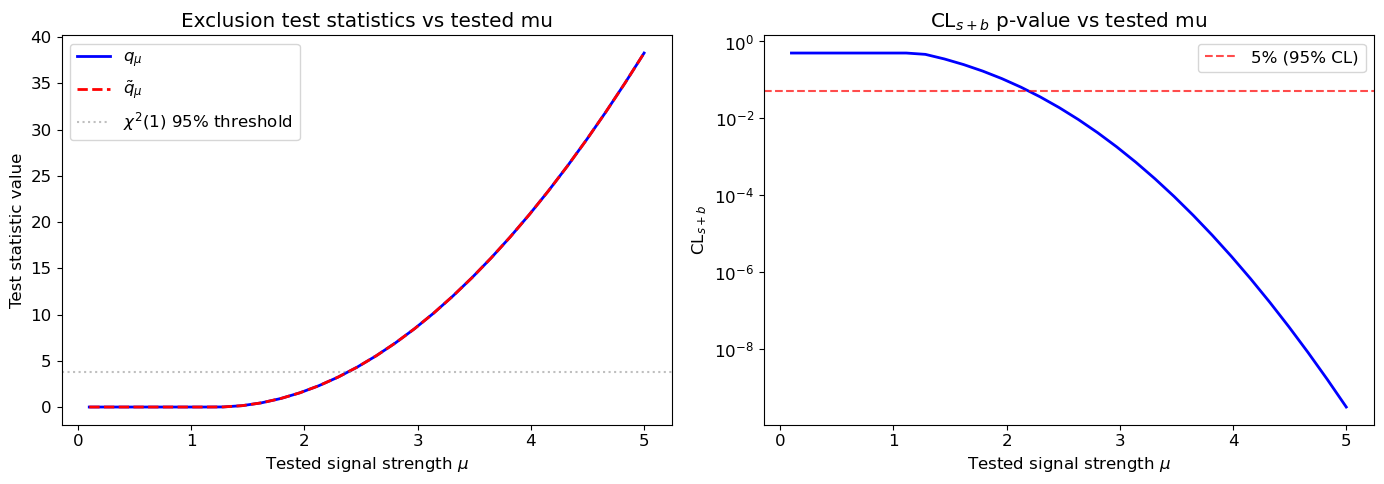

In [6]:
mu_values = np.linspace(0.1, 5.0, 30)
q0_val, _ = compute_q0(model, "mu")
qmu_vals = []
qt_vals = []
pvals_sb = []

for mu_t in mu_values:
    qm, _ = compute_qmu(model, "mu", mu_t)
    qt, mh = compute_qtilde_mu(model, "mu", mu_t)
    qmu_vals.append(qm)
    qt_vals.append(qt)
    sig = compute_asimov_sigma(model, "mu", mu_t)
    clsb, clb = pvalues_qtilde_mu(qt, mu_t, mh, sig)
    pvals_sb.append(clsb)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(mu_values, qmu_vals, "b-", linewidth=2, label=r"$q_\mu$")
ax1.plot(mu_values, qt_vals, "r--", linewidth=2, label=r"$\tilde{q}_\mu$")
ax1.axhline(3.84, color="gray", ls=":", alpha=0.5, label=r"$\chi^2(1)$ 95% threshold")
ax1.set_xlabel(r"Tested signal strength $\mu$")
ax1.set_ylabel("Test statistic value")
ax1.set_title("Exclusion test statistics vs tested mu")
ax1.legend()

ax2.semilogy(mu_values, pvals_sb, "b-", linewidth=2)
ax2.axhline(0.05, color="red", ls="--", alpha=0.7, label="5% (95% CL)")
ax2.set_xlabel(r"Tested signal strength $\mu$")
ax2.set_ylabel(r"CL$_{s+b}$")
ax2.set_title(r"CL$_{s+b}$ p-value vs tested mu")
ax2.legend()

plt.tight_layout()
plt.show()

## 5.6 The 5-sigma convention

Particle physics requires $Z \geq 5$ ($p \leq 2.87 \times 10^{-7}$)
to claim a discovery. This stringent threshold accounts for the
look-elsewhere effect and the historical false positives that plagued
the field. The $q_0$ test statistic provides the bridge: large $q_0$
means the background-only hypothesis is a poor fit to data, and
$\sqrt{q_0} \geq 5$ triggers a discovery claim.

In [7]:
# What q0 values correspond to key significance thresholds?
for z_target in [1, 2, 3, 5]:
    q0_needed = z_target ** 2
    p_val = stats.norm.sf(z_target)
    print(f"  Z = {z_target}: q0 >= {q0_needed:6.1f}, p <= {p_val:.2e}")

  Z = 1: q0 >=    1.0, p <= 1.59e-01
  Z = 2: q0 >=    4.0, p <= 2.28e-02
  Z = 3: q0 >=    9.0, p <= 1.35e-03
  Z = 5: q0 >=   25.0, p <= 2.87e-07


## Exercises

**Exercise 5.1.** Generate 1000 pseudo-experiments under the
background-only hypothesis ($\mu = 0$). For each, compute $q_0$ and
convert to a Z-value. Plot the distribution of Z and overlay the
expected half-Gaussian distribution. What fraction of experiments
exceed $Z = 2$?

**Exercise 5.2.** For the model in this notebook, compute the expected
discovery significance using the Asimov dataset. Build an Asimov model
at $\mu = 1.5$ and compute $q_0$ on that dataset. Compare $\sqrt{q_0}$
with the median significance from Exercise 5.1 (if you generated toys
at $\mu = 1.5$).

**Exercise 5.3.** Demonstrate the difference between $q_\mu$ and
$\tilde{q}_\mu$. Generate pseudo-data with a large downward fluctuation
(seed until $\hat{\mu} < 0$) and compute both test statistics at
$\mu_{\text{test}} = 1.0$. Explain why $\tilde{q}_\mu > q_\mu$ when
$\hat{\mu} < 0$.

## References

G. Cowan, K. Cranmer, E. Gross, O. Vitells. "Asymptotic formulae for
likelihood-based tests of new physics." Eur. Phys. J. C71 (2011) 1554.
arXiv:1007.1727.

G. Cowan, *Statistical Data Analysis*, Lectures 6 and 7.

H. Prosper, "Statistics in Particle Physics", Lectures 6 through 9.

K. Cranmer, "Neyman-Pearson lemma", in *Statistics and Data Science*.